#Auxillary tutorial 4: MCMC credible regions

*This auxillary tutorial was presented in lecture 8 and was generated from an IPython notebook.  You can download the notebook [here](aux4_mcmc_credible_region.ipynb).*

Before we begin, we import our favorite modules, as always.  For this little tutorial, we are going to use [Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/) to make our plots look pretty.

In [1]:
# As usual, import modules
from __future__ import division, absolute_import, \
                                    print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emcee

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline 

# Use seaborn styles for nice-looking plots
import seaborn as sns
sns.set()

## Some distributions to sample

We will generate some sample distributions to sample using MCMC.

In [2]:
def log_exp(x, lam):
    """
    Log of unnormalized exponential distribution with a given lambda.
    """
    if x < 0:
        return -np.inf
    
    return -lam * x

def log_gauss(x, mu, sigma):
    """
    Log of unnormalized exponential distribution with a given mu, sigma.
    """
    return -(x - mu)**2 / 2.0 / sigma**2

def log_sum_of_gauss(x, mu_1, mu_2, sigma_1, sigma_2):
    """
    Log of sum of Gaussians.
    """
    gauss_1 = np.exp(-(x - mu_1)**2 / 2.0 / sigma_1**2) \
                    / np.sqrt(2.0 * np.pi) / sigma_1
    gauss_2 = np.exp(-(x - mu_2)**2 / 2.0 / sigma_2**2) \
                    / np.sqrt(2.0 * np.pi) / sigma_2
    return np.log(gauss_1 + gauss_2)

def log_longtail(x, mu, sigma):
    """
    Log of unnormalized lognormal distribution.
    """
    if x <= 0.0:
        return -np.inf
    
    return np.log(x / (x + 5.0)**5)

## Generation of MCMC samples

We'll use MCMC to sample these to get chains.

In [3]:
# Parametrize dists
lam = 1.0
mu = 1.0
sigma = 0.25
mu_2 = 3.0
sigma_2 = 0.5

# Set up MCMC parameters
n_dim = 1        # number of parameters in the model
n_walkers = 10   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0.1, 2.0, n_walkers)

# Set up the EnsembleSampler instances
sampler = 4 * [None]
names = ['exponential', 'Gaussian', '2 Gaussians', 'long tail']
sampler[0] = emcee.EnsembleSampler(n_walkers, n_dim, log_exp, args=(lam,))
sampler[1] = emcee.EnsembleSampler(n_walkers, n_dim, log_gauss, 
                                      args=(mu, sigma))
sampler[2] = emcee.EnsembleSampler(
        n_walkers, n_dim, log_sum_of_gauss, args=(mu, mu_2, sigma, sigma_2))
sampler[3] = emcee.EnsembleSampler(n_walkers, n_dim, log_longtail, 
                                          args=(mu, sigma))

# Do the burn-ins and samples
for i in range(4):
    pos, prob, state = sampler[i].run_mcmc(p0, n_burn, storechain=False)
    sampler[i].reset()
    pos, prob, state = sampler[i].run_mcmc(pos, n_steps)

# Make it a tuple to avoid mutability
sampler = tuple(sampler)

Let's look at what we got from MCMC.

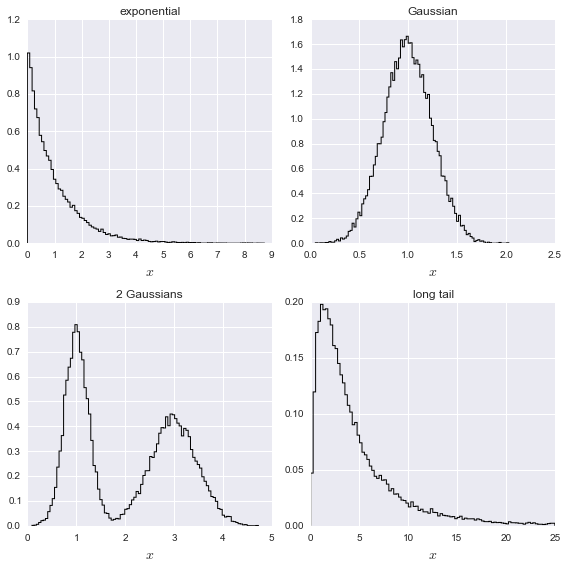

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sps = [(0,0), (0,1), (1,0), (1,1)]
for i in range(4):
    # In case of long tail, only keep smaller values
    inds = sampler[i].flatchain[:,0] < 25.0

    # Make histogram
    n, b, p = ax[sps[i]].hist(sampler[i].flatchain[inds,0], histtype='step', 
                       color='k', normed=True, bins=100, lw=1)
    
    # Plot labeling
    ax[sps[i]].set_xlabel(r'$x$', fontsize=14)
    ax[sps[i]].set_title(names[i])
plt.tight_layout()
    

## Summarizing the MCMC results with error bars

We will consider three commonly used ways of plotting a value plus error bar.  We will use a 95% credible region for this demonstration.

1. **mean $\pm$ standard deviation**: The most commonly used confidence interval is $\mu \pm k\sigma$, where $k$ is chosen to give the appropriate confidence interval, assuming the posterior is Gaussian.  We'll do 95%, which means $k = 1.96$.
2. **median with quantile**: The posterior need not be Gaussian.  If it is not, we would like a more robust was to summarize it.  A simple method is to report the median, and then give lower and upper bounds to the error bar based on quantile.  In our case, we would report the 2.5th percentile and the 97.5th percentile.
3. **mode with HPD**: This method uses the **highest posterior density** interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior.  So, we report the mode and then the bounds on the HPD interval.

We'll start by computing the mean, standard deviation, median, and quantiles, since these are easy to compute with NumPy.

In [5]:
# Compute mean and std.
means = np.empty(4)
stds = np.empty(4)
for i in range(4):
    means[i] = sampler[i].flatchain[:,0].mean()
    stds[i] = sampler[i].flatchain[:,0].std()

# Compute quantile credible regions (use np.percentile)
perctiles = np.empty((4, 3))
for i in range(4):
    perctiles[i,:] = np.percentile(sampler[i].flatchain[:,0], 
                                   [2.5, 50, 97.5])

Computation of the HPD is a little trickier.  The function below will compute the HPD interval.  The idea is that we rank-order the MCMC trace.  We know that the number of samples that are included in the HPD is 0.95 times the total number of MCMC sample.  We then consider all intervals that contain that many samples and find the shortest one.

In [6]:
def hpd(trace, mass_frac) :
    """
    Returns HPD interval
    """
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)
    
    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n)
    
    # Get width (in units of data) 
    # of all intervals containing n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]
    
    # Pick out minimal interval
    min_int = np.argmin(int_width)
    
    # Return interval
    return np.array([d[min_int], d[min_int+n_samples]])

With this function in hand, we can compute the HPD and get the modes and error bars.

In [7]:
# Compute HPD credible regions
hpds = 4*[None]
modes = np.empty(4)
for i in range(4):
    hpds[i] = hpd(sampler[i].flatchain[:,0], 0.95)
    modes[i] = sampler[i].flatchain[np.argmax(sampler[i].flatlnprobability)]

Now that we have everything in hand, we can make our plots with error bars.

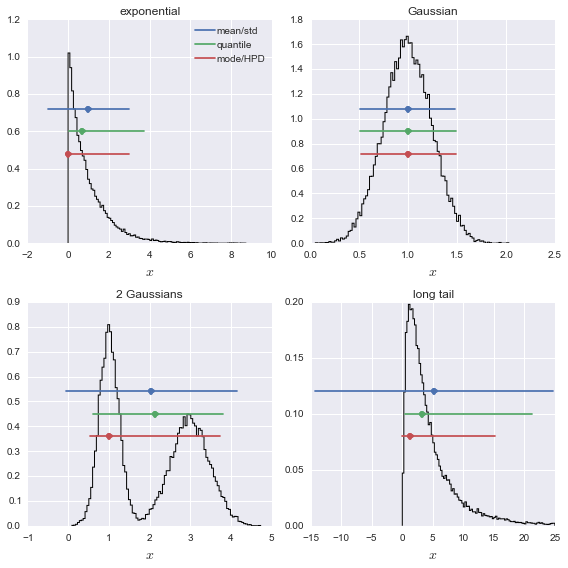

In [8]:
# Show results on plots
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    # In case of long tail, only keep smaller values
    inds = sampler[i].flatchain[:,0] < 25.0

    # Make histogram
    n, b, p = ax[sps[i]].hist(sampler[i].flatchain[inds,0], histtype='step', 
                       color='k', normed=True, bins=100, lw=1)

    # Get y-value for Gaussian error bar
    ylims = ax[sps[i]].get_ylim()
    y_gauss = ylims[1] / 2.0 + ylims[1] * 0.1

    # Get y-value for quantile error bar
    y_quantile = ylims[1] / 2.0
    
    # Get y-value for HPD error bar
    y_hpd = ylims[1] / 2.0 - ylims[1] * 0.1

    # Plot Gaussian error bar
    dot, = ax[sps[i]].plot(means[i], y_gauss, 'o')
    ax[sps[i]].plot([means[i] - 1.96 * stds[i], means[i] + 1.96 * stds[i]], 
                    [y_gauss, y_gauss], '-', color=dot.get_color(),
                    label='mean/std')

    # Plot quantile error bar
    dot, = ax[sps[i]].plot(perctiles[i,1], y_quantile, 'o')
    ax[sps[i]].plot([perctiles[i,0], perctiles[i,2]], 
                    [y_quantile, y_quantile], '-', color=dot.get_color(),
                    label='quantile')
    
    # Plot HPD error bar
    dot, = ax[sps[i]].plot(modes[i], y_hpd, 'o')
    ax[sps[i]].plot([hpds[i][0], hpds[i][1]], [y_hpd, y_hpd], '-', 
                    color=dot.get_color(), label='mode/HPD')
    
    # Plot labeling
    ax[sps[i]].set_xlabel(r'$x$', fontsize=14)
    ax[sps[i]].set_title(names[i])
    ax[sps[i]].set_ylim(ylims)

# Put in a legend
ax[0,0].legend(loc='upper right')
plt.tight_layout()

We see that method 1 does not respect bounds on the posterior, nor any asymmetry.  The other two methods, in my opinion, have similar value.  The quantile approach is very easy to interpret, definitely moreso than mode + HPD.  However, it is nice to know the most probable value, so HPD has this going for it.  In any case, attempting to describe a multi-modal posterior with an error bar is misleading and futile.

One issue that may be worrying you is how to report the asymmetric error bars in text.  For the example of the long tailed, we may report the mode with HPD as $1.25^{+13.56}_{-1.22}$.